# First Approach - Recurrent Neural Network

In [1]:
from IPython.display import clear_output
from pivottablejs import pivot_ui
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.widgets import Slider, TextBox, Button
import sqlite3
import time
import pandas as pd
import numpy as np
import os

import sys
sys.path.append('..') # in order to import modules from my own package
from packageMeinhart import functionsMasterProjectMeinhart as fmpm
from packageMeinhart.functionsMasterProjectMeinhart import print_precision_recall_accuracy
from packageMeinhart.functionsMasterProjectMeinhart import print_misclassified_data_points


## Class to handle data for RNN

In [2]:
def load_data_from_database(data_base_path='DataBase_Physio_with_nonEx.db'):
    '''
    Function to load the following data from data base:
        - subject IDs
        - exercise abbreviations
        - number of repetitions
        - sequence numbers
        - start times
        - stop times
        - csv-file name
    
    Parameters
    ----------
    data_base_path : string
        Path to data base.
    
    Returns
    -------
    DataFrame
        DataFrame with the listet information (see above).
    '''
    # Connect to an existing database
    conn = sqlite3.connect(data_base_path)
    cur = conn.cursor()

    # sql command to extract data
    query_sql = """
        SELECT e.subject_id,
        p.abbreviation,
        e.num_rep,
        r.sequence_num,
        r.start_time, r.stop_time,
        e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        """
    
    # get data from data base and close connection
    all_data_points_df = pd.read_sql_query(query_sql, conn)
    conn.close()
    
    return all_data_points_df

In [3]:
def select_data_points_from_df(all_data_points_df,
                               subject_ids=-1,
                               subject_ids_complementary=[],
                               reps=-1,
                               abbrs=-1,
                               with_non_Ex=True,
                               sub_id_key='subject_id',
                               num_rep_key='num_rep',
                               abbreviation_key='abbreviation'):
    '''
    Function to select data points from a DataFrame based on subject IDs,
    number of repetitions and exercise abbreviations.
    
    Parameters
    ----------
    all_data_points_df : pandas DataFrame
        DataFrame with all data points.
    
    subject_ids : int or list
        Subject IDs to select (e.g. [1, 2, 3]).
        --> default -1: Select all subjects.
        
    subject_ids_complementary : int or list
        If subject_ids is -1 --> select only subjects not in subject_ids_complementary.
        
    reps : int or list
        Repetition numbers to select (e.g. [5, 10]).
        --> default -1: Select all repetitions.
        
    abbrs : int or list
        Exercise abbreviations to select (e.g. ['RF', 'SA']).
        --> default -1: Select all exercise abbreviations.
    
    with_non_Ex : boolean
        If False --> omit non exercise data (data points with zero repetitions).
        
    sub_id_key : string
        Key of the DataFrame for subject IDs.
        
    num_rep_key : string
        Key of the DataFrame for repetition numbers.
        
    abbreviation_key : string
        Key of the DataFrame for exercise abbreviations.
    
    Returns
    -------
    DataFrame
        DataFrame with selected data points.
    '''
    
    data_points_df = all_data_points_df.copy()
    
    # select the subject IDs
    if subject_ids is -1 and subject_ids_complementary:
        if not isinstance(subject_ids_complementary, list): # if not list --> make list
            subject_ids_complementary = [subject_ids_complementary]
        data_points_df = data_points_df.loc[~data_points_df[sub_id_key].isin(subject_ids_complementary)]
        
    elif subject_ids is not -1:
        if not isinstance(subject_ids, list): # if not list --> make list
            subject_ids = [subject_ids]
        data_points_df = data_points_df.loc[data_points_df[sub_id_key].isin(subject_ids)]

    # select the repetition numbers
    if reps is not -1:
        if not isinstance(reps, list): # if not list --> make list
            reps = [reps]
        if with_non_Ex is True:
            reps.append(0) # zero repetitions correspond to non exercise data
        data_points_df = data_points_df.loc[data_points_df[num_rep_key].isin(reps)]

    elif with_non_Ex is False:
        data_points_df = data_points_df.loc[data_points_df[num_rep_key] != 0]
        
    # select the exercise abbreviations
    if abbrs is not -1:
        if not isinstance(abbrs, list): # if not list --> make list
            abbrs = [abbrs]
        data_points_df = data_points_df.loc[data_points_df[abbreviation_key].isin(abbrs)]

    return data_points_df

In [4]:
def print_progress_func(current_num, max_num, prev_prog, add_info=None):
    '''
    Function to print progress [%] in a loop.
    
    Parameters
    ----------
    current_num : int
        Number of the current run in a loop.
        
    max_num : int
        Maximum number of runs in a loop.
        
    prev_prog : int
        Previous progress, to print only if necessary.
        
    add_info : str
        Additional information to print instead of "Progress".
    
    Returns
    -------
    int
        Previous progress, important for next run.
    '''
    new_prog = int(current_num/max_num*100)
    
    if new_prog > prev_prog:
        clear_output(wait=True)
        
        if isinstance(add_info, str):
            print(add_info + ' {:3d}%'.format(new_prog))
        else:
            print('Progress: {:3d}%'.format(new_prog))
        
    return new_prog

In [5]:
def generate_sequences_from_separate_repetitions(data_points_df,
                   max_sequence_length=6,
                   orig_sampling_rate=256,
                   new_sampling_rate=8,
                   cutoff=10,
                   order=6,
                   csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                   csv_skiprows=0,
                   csv_separator=',',
                   signal_abbrs=['Acc','Gyr'],
                   signal_orientations=['x','y','z'],
                   labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
                   abbreviation_key='abbreviation',
                   start_time_key='start_time',
                   stop_time_key='stop_time',
                   csv_file_key='csv_file',
                   print_progress=True,
                   progress_info='Generate sequences...'):
    '''
    Function to generate sequences from separate repetitions, changing the sampling rate
    and saving them to a tensor.
    
    Parameters
    ----------
    data_points_df : DataFrame
        DataFrame with information about data points (see load_data_from_database()).
        
    max_sequence_length : int or float
        Maximum sequence length to consider in seconds.
        
    orig_sampling_rate : int or float
        Original sampling rate of the signals in Hz.
        
    new_sampling_rate : int or float
        New sampling rate of the signals in Hz.
        
    cutoff : int or float
        Cutoff frequency for filtering.
    
    order : int
        Order of butterworth filter.
        
    csv_data_dir : string
        Directory of signal data csv-files.
        
    csv_skiprows : int
        Number of rows to skip for signal data csv-files.
        
    csv_separator : string
        Separator for signal data csv-files.
        
    signal_abbrs : list of strings
        Abbreviations of the signals (e.g. ['Acc','Gyr']).
    
    signal_orientations : list of strings
        Orientations of the signals (e.g. ['x','y','z']).
        
    labels_abbr2num_dict : dict
        Dictionary to convert exercise abbreviations to number (e.g. ={'RF':0,'RO':1,'RS':2, ... }).
    
    abbreviation_key : strings
        Exercise abbreviation key for DataFrame which contains data base entries.
        
    start_time_key : strings
        Start time key for DataFrame which contains data base entries.
        
    stop_time_key : strings
        Stop time key for DataFrame which contains data base entries.
        
    csv_file_key : strings
        csv-file key for DataFrame which contains data base entries.
        
    print_progress : boolean
        If True --> print progress at signal sequences generation.
        
    progress_info : strings
        Additional information to print with progress.
        
    
    Returns
    -------
    X_all, y_all, seqlens_all
        
        X_all ... tensor with signal sequences (dimensions: [number of data points, 
                                                             max sequence length, 
                                                             number of signals])
        y_all ... array with labels
        seqlens_all ... array with sequence lengths
    '''
    
    # max index of new sequences
    max_sequ_index = max_sequence_length * new_sampling_rate
    
    # number of signals (Acc: x, y, z; Gyr: x, y, z --> 6 signals)
    num_signals = len(signal_abbrs) * len(signal_orientations)
    
    # number to exercise-abbreviations dict
    labels_num2abbr_dict = {num: abbr for abbr, num in labels_abbr2num_dict.items()}
                                                   
    # create array for labels
    y_all = np.zeros(len(data_points_df), dtype=np.int8)
    
    # create tensor for sequences
    X_all = np.zeros((len(data_points_df), max_sequ_index, num_signals))
    
    # create matrix for sequence lengths
    seqlens_all = np.zeros(len(data_points_df), dtype=np.int)
    
    # sampling rate ratio of original and new sampling rate (e.g. if ratio = 32 --> take every 32nd index)
    sampling_rate_ratio = orig_sampling_rate / new_sampling_rate

    # location counter for the sequence tensor
    loc_count = 0

    # variables for progress printing
    if print_progress:
        prog_count = 0
        max_count = len(data_points_df.csv_file.unique()) # number of unique csv-files
        prev_progress = 0 # previous progress

    # going through all csv-files (unique --> only once for each file)
    for current_csv_file in data_points_df.csv_file.unique():

        # join file path
        file_path = os.path.join(csv_data_dir, current_csv_file)

        # load the signal data of the current file
        selected_data_df = pd.read_csv(file_path, skiprows=csv_skiprows, sep=csv_separator)
        
        # write data with selected signals to dict
        selected_data = {}
        for sig in signal_abbrs:
            selected_data[sig] = selected_data_df.filter(regex=sig+'*').values
            
        # filter data with butterworth filter and save to new dictionary
        selected_data_filt = {}
        for sig in signal_abbrs:
            selected_data_filt[sig] = fmpm.butter_lowpass_filter(selected_data[sig], 
                                                                 cutoff=cutoff, 
                                                                 fs=orig_sampling_rate, 
                                                                 order=order)
    
        # data frame with all repetitions of the current file
        current_data_points = data_points_df.loc[data_points_df[csv_file_key] == current_csv_file]

        # going through all repetitions of the current file
        for ii in range(len(current_data_points)):
            
            # get start and stop indices of current data point (current repetition)
            start_time = float(current_data_points.reset_index().loc[ii, start_time_key])
            stop_time = float(current_data_points.reset_index().loc[ii, stop_time_key])
            start_idx = round(start_time * orig_sampling_rate)
            stop_idx = round(stop_time * orig_sampling_rate)

            # consider the new sampling rate for signal data selection
            new_indices = np.arange(start_idx, stop_idx, sampling_rate_ratio).round().astype(int)
            
            # check if array of new indices is longer than max_sequ_index
            if len(new_indices) > max_sequ_index:
                new_indices = new_indices[:max_sequ_index] # take only that much indices
            
            # add current sequences with new sampling rate
            for kk, sig in enumerate(signal_abbrs):
                for ll in range(len(signal_orientations)):
                    # explanation: X_all[index_of_current_data_point, 
                    #                    select_all_until_length_of_new_signal_data, 
                    #                    index_of_current_signal (0...5)]
                    X_all[loc_count,:len(new_indices),kk*len(signal_orientations)+ll] = \
                        selected_data_filt[sig][new_indices,ll]

            # add current label
            current_ex_abbr = current_data_points.reset_index().loc[ii,abbreviation_key]
            y_all[loc_count] = labels_abbr2num_dict[current_ex_abbr]
            
            # add current sequence length
            seqlens_all[loc_count] = len(new_indices)

            loc_count += 1

        # print progress of feauture generation
        if print_progress:
            prog_count += 1
            prev_progress = print_progress_func(prog_count, max_count, prev_progress, add_info=progress_info)
    
    if print_progress:
        clear_output()
    
    return X_all, y_all, seqlens_all

In [6]:
def generate_sequences_from_repetition_blocks(data_points_df,
                   max_sequence_length=80,
                   orig_sampling_rate=256,
                   new_sampling_rate=8,
                   cutoff=10,
                   order=6,
                   csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                   csv_skiprows=0,
                   csv_separator=',',
                   signal_abbrs=['Acc','Gyr'],
                   signal_orientations=['x','y','z'],
                   labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
                   abbreviation_key='abbreviation',
                   csv_file_key='csv_file',
                   print_progress=True,
                   progress_info='Generate sequences...'):
    '''
    Function to generate sequences from whole repetition blocks, changing the sampling rate
    and saving them to a tensor.
    
    Parameters
    ----------
    data_points_df : DataFrame
        DataFrame with information about data points (see load_data_from_database()).
        
    max_sequence_length : int or float
        Maximum sequence length to consider in seconds.
        
    orig_sampling_rate : int or float
        Original sampling rate of the signals in Hz.
        
    new_sampling_rate : int or float
        New sampling rate of the signals in Hz.
        
    cutoff : int or float
        Cutoff frequency for filtering.
    
    order : int
        Order of butterworth filter.
        
    csv_data_dir : string
        Directory of signal data csv-files.
        
    csv_skiprows : int
        Number of rows to skip for signal data csv-files.
        
    csv_separator : string
        Separator for signal data csv-files.
        
    signal_abbrs : list of strings
        Abbreviations of the signals (e.g. ['Acc','Gyr']).
    
    signal_orientations : list of strings
        Orientations of the signals (e.g. ['x','y','z']).
        
    labels_abbr2num_dict : dict
        Dictionary to convert exercise abbreviations to number (e.g. ={'RF':0,'RO':1,'RS':2, ... }).
    
    abbreviation_key : strings
        Exercise abbreviation key for DataFrame which contains data base entries.
        
    csv_file_key : strings
        csv-file key for DataFrame which contains data base entries.
        
    print_progress : boolean
        If True --> print progress at signal sequences generation.
        
    progress_info : strings
        Additional information to print with progress.
        
    
    Returns
    -------
    X_all, y_all, seqlens_all
        
        X_all ... tensor with signal sequences (dimensions: [number of data points, 
                                                             max sequence length, 
                                                             number of signals])
        y_all ... array with labels
        seqlens_all ... array with sequence lengths
    '''
    
    # max index of new sequences
    max_sequ_index = max_sequence_length * new_sampling_rate
    
    # number of signals (Acc: x, y, z; Gyr: x, y, z --> 6 signals)
    num_signals = len(signal_abbrs) * len(signal_orientations)
    
    # number to exercise-abbreviations dict
    labels_num2abbr_dict = {num: abbr for abbr, num in labels_abbr2num_dict.items()}
    
    # every csv-file is one repetition block --> one data point
    csv_files_unique = data_points_df.csv_file.unique()
    
    # create array for labels
    y_all = np.zeros(len(csv_files_unique), dtype=np.int8)
    
    # create tensor for sequences
    X_all = np.zeros((len(csv_files_unique), max_sequ_index, num_signals))
    
    # create matrix for sequence lengths
    seqlens_all = np.zeros(len(csv_files_unique), dtype=np.int)
    
    # sampling rate ratio of original and new sampling rate (e.g. if ratio = 32 --> take every 32nd index)
    sampling_rate_ratio = orig_sampling_rate / new_sampling_rate

    # location counter for the sequence tensor
    loc_count = 0

    # variables for progress printing
    if print_progress:
        prog_count = 0
        max_count = len(csv_files_unique) # number of unique csv-files
        prev_progress = 0 # previous progress

    # going through all csv-files (unique --> only once for each file)
    for current_csv_file in csv_files_unique:

        # join file path
        file_path = os.path.join(csv_data_dir, current_csv_file)

        # load the signal data of the current file
        selected_data_df = pd.read_csv(file_path, skiprows=csv_skiprows, sep=csv_separator)
        
        # write data with selected signals to dict
        selected_data = {}
        for sig in signal_abbrs:
            selected_data[sig] = selected_data_df.filter(regex=sig+'*').values
            
        # filter data with butterworth filter and save to new dictionary
        selected_data_filt = {}
        for sig in signal_abbrs:
            selected_data_filt[sig] = fmpm.butter_lowpass_filter(selected_data[sig], 
                                                                 cutoff=cutoff, 
                                                                 fs=orig_sampling_rate, 
                                                                 order=order)
            
        # start and stop indices of current data point (current repetition block)
        start_idx = 0
        # all signal columns must have the same length
        stop_idx = len(selected_data_filt[signal_abbrs[0]][:,0])

        # consider the new sampling rate for signal data selection
        new_indices = np.arange(start_idx, stop_idx, sampling_rate_ratio).round().astype(int)
            
        # check if array of new indices is longer than max_sequ_index
        if len(new_indices) > max_sequ_index:
            new_indices = new_indices[:max_sequ_index] # take only that much indices
            
        # add current sequences with new sampling rate
        for kk, sig in enumerate(signal_abbrs):
            for ll in range(len(signal_orientations)):
                # explanation: X_all[index_of_current_data_point, 
                #                    select_all_until_length_of_new_signal_data, 
                #                    index_of_current_signal (0...5)]
                X_all[loc_count,:len(new_indices),kk*len(signal_orientations)+ll] = \
                    selected_data_filt[sig][new_indices,ll]

        # add current label
        # data frame with all repetitions of the current file
        current_data_points = data_points_df.loc[data_points_df[csv_file_key] == current_csv_file]
        current_ex_abbr = current_data_points.reset_index().loc[0,abbreviation_key]
        y_all[loc_count] = labels_abbr2num_dict[current_ex_abbr]
            
        # add current sequence length
        seqlens_all[loc_count] = len(new_indices)

        loc_count += 1

        # print progress of feauture generation
        if print_progress:
            prog_count += 1
            prev_progress = print_progress_func(prog_count, max_count, prev_progress, add_info=progress_info)
    
    if print_progress:
        clear_output()
    
    return X_all, y_all, seqlens_all

In [7]:
class PhysioData_RNN():
    '''
    Class to handle signal data for RNN.
    
    Detailed description follows ...
    
    For now: look at docstrings of the following functions:
        - load_data_from_database()
        - select_data_points_from_df()
        - generate_sequences_from_separate_repetitions()
        - generate_sequences_from_repetition_blocks()
    
    '''
    def __init__(self,
                 test_subject_ids=-1,
                 train_subject_ids=-1,
                 test_rep_nums=-1,
                 train_rep_nums=-1,
                 test_ex_abbrs=-1,
                 train_ex_abbrs=-1,
                 with_non_Ex=True,
                 max_sequence_length_testing=6,
                 max_sequence_length_training=6,
                 orig_sampling_rate=256,
                 new_sampling_rate=8,
                 whole_rep_blocks_as_data_points_for_testing=False,
                 whole_rep_blocks_as_data_points_for_training=False,
                 cutoff=10,
                 order=6,
                 csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                 csv_skiprows=0,
                 csv_separator=',',
                 data_base_path='E:\Physio_Data\DataBase_Physio_with_nonEx.db',
                 print_progress=True,
                 signal_abbrs=['Acc','Gyr'],
                 signal_orientations=['x','y','z'],
                 labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
                 sub_id_key='subject_id',
                 num_rep_key='num_rep',
                 abbreviation_key='abbreviation',
                 start_time_key='start_time',
                 stop_time_key='stop_time',
                 csv_file_key='csv_file'):
        
        # load all data from data points
        self.all_data_points_df = load_data_from_database(data_base_path)
        
        # load data points for testing
        self.test_data_points_df =  select_data_points_from_df(self.all_data_points_df,
                                                               subject_ids=test_subject_ids,
                                                               subject_ids_complementary=[],
                                                               reps=test_rep_nums,
                                                               abbrs=test_ex_abbrs,
                                                               with_non_Ex=with_non_Ex,
                                                               sub_id_key=sub_id_key,
                                                               num_rep_key=num_rep_key,
                                                               abbreviation_key=abbreviation_key)
        
        # load data points for training
        self.train_data_points_df = select_data_points_from_df(self.all_data_points_df,
                                                               subject_ids=train_subject_ids,
                                                               subject_ids_complementary=test_subject_ids,
                                                               reps=train_rep_nums,
                                                               abbrs=train_ex_abbrs,
                                                               with_non_Ex=with_non_Ex,
                                                               sub_id_key=sub_id_key,
                                                               num_rep_key=num_rep_key,
                                                               abbreviation_key=abbreviation_key)
        
        # take whole repetition blocks as data points for testing
        if whole_rep_blocks_as_data_points_for_testing is True:
            
            # generate sequences for testing
            self.X_test, self.y_test, self.seqlens_test = generate_sequences_from_repetition_blocks(
                                                                   self.test_data_points_df,
                                                                   max_sequence_length=max_sequence_length_testing,
                                                                   orig_sampling_rate=orig_sampling_rate,
                                                                   new_sampling_rate=new_sampling_rate,
                                                                   cutoff=cutoff,
                                                                   order=order,
                                                                   csv_data_dir=csv_data_dir,
                                                                   csv_skiprows=csv_skiprows,
                                                                   csv_separator=csv_separator,
                                                                   signal_abbrs=signal_abbrs,
                                                                   signal_orientations=signal_orientations,
                                                                   labels_abbr2num_dict=labels_abbr2num_dict,
                                                                   abbreviation_key=abbreviation_key,
                                                                   csv_file_key=csv_file_key,
                                                                   print_progress=print_progress,
                                                                   progress_info='Generate sequences for testing...')
        
        # take single repetitions as data points for testing
        else:
            
            # generate sequences for testing
            self.X_test, self.y_test, self.seqlens_test = generate_sequences_from_separate_repetitions(
                                                                   self.test_data_points_df,
                                                                   max_sequence_length=max_sequence_length_testing,
                                                                   orig_sampling_rate=orig_sampling_rate,
                                                                   new_sampling_rate=new_sampling_rate,
                                                                   cutoff=cutoff,
                                                                   order=order,
                                                                   csv_data_dir=csv_data_dir,
                                                                   csv_skiprows=csv_skiprows,
                                                                   csv_separator=csv_separator,
                                                                   signal_abbrs=signal_abbrs,
                                                                   signal_orientations=signal_orientations,
                                                                   labels_abbr2num_dict=labels_abbr2num_dict,
                                                                   abbreviation_key=abbreviation_key,
                                                                   start_time_key=start_time_key,
                                                                   stop_time_key=stop_time_key,
                                                                   csv_file_key=csv_file_key,
                                                                   print_progress=print_progress,
                                                                   progress_info='Generate sequences for testing...')
            
        # take whole repetition blocks as data points for training
        if whole_rep_blocks_as_data_points_for_training is True:

            # generate sequences for training
            self.X_train, self.y_train, self.seqlens_train = generate_sequences_from_repetition_blocks(
                                                                   self.train_data_points_df,
                                                                   max_sequence_length=max_sequence_length_training,
                                                                   orig_sampling_rate=orig_sampling_rate,
                                                                   new_sampling_rate=new_sampling_rate,
                                                                   cutoff=cutoff,
                                                                   order=order,
                                                                   csv_data_dir=csv_data_dir,
                                                                   csv_skiprows=csv_skiprows,
                                                                   csv_separator=csv_separator,
                                                                   signal_abbrs=signal_abbrs,
                                                                   signal_orientations=signal_orientations,
                                                                   labels_abbr2num_dict=labels_abbr2num_dict,
                                                                   abbreviation_key=abbreviation_key,
                                                                   csv_file_key=csv_file_key,
                                                                   print_progress=print_progress,
                                                                   progress_info='Generate sequences for training...')
            
        # take single repetitions as data points for training
        else:

            # generate sequences for training
            self.X_train, self.y_train, self.seqlens_train = generate_sequences_from_separate_repetitions(
                                                                   self.train_data_points_df,
                                                                   max_sequence_length=max_sequence_length_training,
                                                                   orig_sampling_rate=orig_sampling_rate,
                                                                   new_sampling_rate=new_sampling_rate,
                                                                   cutoff=cutoff,
                                                                   order=order,
                                                                   csv_data_dir=csv_data_dir,
                                                                   csv_skiprows=csv_skiprows,
                                                                   csv_separator=csv_separator,
                                                                   signal_abbrs=signal_abbrs,
                                                                   signal_orientations=signal_orientations,
                                                                   labels_abbr2num_dict=labels_abbr2num_dict,
                                                                   abbreviation_key=abbreviation_key,
                                                                   start_time_key=start_time_key,
                                                                   stop_time_key=stop_time_key,
                                                                   csv_file_key=csv_file_key,
                                                                   print_progress=print_progress,
                                                                   progress_info='Generate sequences for training...')
    
    
    def get_train_batch(self, batch_size):
        '''
        Method to get batch with randomly selected training data.
        
        Parameters
        ----------
        batch_size : int
            Number of data points in batch.

        Returns
        -------
        X_train_batch, y_train_batch, seqlens_train_batch
        '''
        
        instance_indices = list(range(len(self.y_train))) # list with all train indices
        np.random.shuffle(instance_indices) # shuffle the train indices
        batch_indices = instance_indices[:batch_size] # randomly select train indices
    
        # select batch data with corresponding indices
        X_train_batch = np.array(self.X_train)[batch_indices]
        y_train_batch = self.y_train[batch_indices]
        seqlens_train_batch = np.array(self.seqlens_train)[batch_indices]

        return X_train_batch, y_train_batch, seqlens_train_batch

    
    # methods to get data
    def get_X_test(self):
        return self.X_test
    
    def get_y_test(self):
        return self.y_test
    
    def get_seqlens_test(self):
        return self.seqlens_test
    
    def get_X_train(self):
        return self.X_train
    
    def get_y_train(self):
        return self.y_train
    
    def get_sequlens_train(self):
        return self.sequlens_train
    
    
    # methods to get data points (DataFrames)
    def get_test_data_points(self):
        return self.test_data_points_df
    
    def get_train_data_points(self):
        return self.train_data_points_df
    
    def get_all_data_points(self):
        return self.all_data_points_df


### Create instance of the class *PhysioData_RNN*

In [8]:
PD_RNN1 = PhysioData_RNN(test_subject_ids=1,
                         max_sequence_length_testing=6,
                         max_sequence_length_training=6,
                         whole_rep_blocks_as_data_points_for_testing=False,
                         whole_rep_blocks_as_data_points_for_training=False)

In [9]:
np.shape(PD_RNN1.get_X_test())

(709, 48, 6)

In [10]:
np.shape(PD_RNN1.get_X_train())

(6120, 48, 6)

In [11]:
PD_RNN1.get_X_test()[0]

array([[-8.85008976e-01,  3.73013764e-01,  2.24020535e-01,
         1.21751042e+01,  1.52829258e+00,  9.10124605e+00],
       [-9.04367908e-01,  8.26654823e-01,  3.67851136e-01,
        -1.01565373e+01,  5.38131320e+00,  7.39012265e+01],
       [-1.01528357e+00,  1.07474501e+00,  3.88348309e-01,
        -2.42753698e+01, -2.82604112e+01,  1.39737623e+02],
       [-1.03430703e+00,  1.15137975e+00,  2.56821977e-01,
         1.23076905e+01, -3.72862596e+01,  1.91338412e+02],
       [-6.34748614e-01,  9.63927847e-01,  2.02384178e-01,
        -7.54283377e+00, -3.91051296e+01,  1.58483358e+02],
       [-2.93779369e-01,  7.57520082e-01,  2.75981183e-01,
        -5.35511185e+00, -2.56590433e+01,  1.41178164e+02],
       [ 1.04911864e-01,  5.41331501e-01,  2.45186189e-01,
         4.44534291e+00, -1.63078708e+01,  1.13614763e+02],
       [ 4.32216915e-01,  4.15494757e-01,  2.65919449e-01,
         1.68503415e+00, -2.25416173e+00,  6.80021935e+01],
       [ 6.11687397e-01,  4.31368824e-01,  2.806

In [12]:
PD_RNN1.get_y_test()[0]

0

In [13]:
PD_RNN1.get_seqlens_test()[0]

21

In [14]:
X_train_batch, y_train_batch, seqlens_train_batch = PD_RNN1.get_train_batch(batch_size=5)

In [15]:
np.shape(X_train_batch)

(5, 48, 6)

In [16]:
y_train_batch

array([10, 10, 10, 10,  3], dtype=int8)

In [17]:
seqlens_train_batch

array([30, 20, 20, 26, 18])

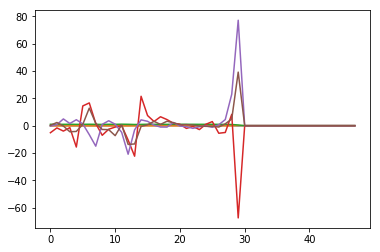

In [18]:
plt.plot(X_train_batch[0,:,:]);

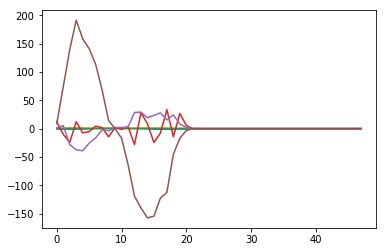

In [19]:
plt.plot(PD_RNN1.get_X_test()[0,:,:]);

## Building a Recurrent Neural Network with *TensorFlow*

In [20]:
import tensorflow as tf

E:\Programme\WinPython-64bit-3.6.2.0Qt5\python-3.6.2.amd64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
# directory to save TensorBoard model summaries
LOG_DIR_ALL = 'E:\Jupyter_Notebooks\Master_Project_Meinhart_git\logs\RNN_with_summaries'

# run the command:
print('tensorboard --logdir=' + LOG_DIR_ALL)

#  --> open http://FlorianMeinhart:6006

tensorboard --logdir=E:\Jupyter_Notebooks\Master_Project_Meinhart_git\logs\RNN_with_summaries


In [22]:
# define parameters for RNN
num_signals = 6 # number of signals (Acc: x, y, z; Gyr: x, y, z)
num_classes = 11 # number of classes
batch_size = 150 # number of data points for each batch
time_steps = None # --> dynamic_rnn
hidden_layer_size_rnn = 128 # number of neurons in the hidden layer of the RNN
num_steps = 1501 # number of steps for training

In [23]:
# get time in order to append corresponding string to log directory
now = datetime.now()
LOG_DIR_TRAIN = LOG_DIR_ALL + now.strftime('\%Y%m%d-%H%M%S' + '_train')
LOG_DIR_TEST = LOG_DIR_ALL + now.strftime('\%Y%m%d-%H%M%S' + '_test')

In [24]:
# create new tensorflow graph
tf.reset_default_graph()

with tf.name_scope('data'):
    inputs = tf.placeholder(tf.float32, shape=[None, time_steps, num_signals], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, num_classes], name='labels')
    seqlens = tf.placeholder(tf.int32, shape=[None], name='seqlens')

with tf.name_scope('RNN_layer'):
    rnn_cell = tf.nn.rnn_cell.BasicRNNCell(hidden_layer_size_rnn)
    #rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size_rnn)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, inputs, sequence_length=seqlens, dtype=tf.float32)

with tf.name_scope('linear_layer'):
    W1 = tf.Variable(tf.truncated_normal([hidden_layer_size_rnn, num_classes], mean=0, stddev=0.1),
                     name='weights_linear')
    b1 = tf.Variable(tf.truncated_normal([num_classes], mean=0, stddev=0.1),
                     name='biases_linear')
    final_output = tf.matmul(states, W1) + b1
    #final_output = tf.matmul(states[0], W1) + b1
    
    final_output_all_states = tf.matmul(tf.reshape(outputs, [-1, hidden_layer_size_rnn]), W1) + b1
    
    softmax = tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_output, labels=labels)
    cross_entropy = tf.reduce_mean(softmax)
    tf.summary.scalar('cross_entropy', cross_entropy)


train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)
#train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(labels,1), tf.argmax(final_output,1), name='correct_prediction')
    accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100
    pred_prob = tf.nn.softmax(logits=final_output, name='predicted_probabilities')
    pred_prob_all_states = tf.nn.softmax(logits=final_output_all_states, name='predicted_probabilities_all_states')
    tf.summary.scalar('accuracy', accuracy)


# merge summaries and create summary writers for training and testing
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(LOG_DIR_TRAIN)
test_writer = tf.summary.FileWriter(LOG_DIR_TEST) 

In [25]:
def one_hot(labels, num_classes):
    '''
    Convert lables to one-hot format.

    Parameters
    ----------
    labels : array or list of integers
        --> e.g. [0, 1, 4, 2, 0]
        
    num_classes : int
        Number of classes.
        (Has to be >= max(labels))

    Returns
    -------
    matrix
        Lables in one-hot format.
    
        --> e.g.
              [[1., 0., 0., 0., 0.],
               [0., 1., 0., 0., 0.],
               [0., 0., 0., 0., 1.],
               [0., 0., 1., 0., 0.],
               [1., 0., 0., 0., 0.]]
    '''
    n = len(labels)
    labels_one_hot = np.zeros((n, num_classes))
    labels_one_hot[range(n), labels] = 1
    return labels_one_hot

In [26]:
# open a session for the created graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_writer.add_graph(sess.graph)
    test_writer.add_graph(sess.graph)
    
    # get test labels in one-hot format
    y_test_all_one_hot = one_hot(PD_RNN1.get_y_test(), num_classes)
    
    # get sequence tensor for testing and corresponding sequence lengths
    X_test_all = PD_RNN1.get_X_test()
    seqlens_test_all = PD_RNN1.get_seqlens_test()
    
    # train the RNN with a defined number of steps
    for step in range(num_steps):
        # get batch data
        x_batch, y_batch, seqlens_batch = PD_RNN1.get_train_batch(batch_size)
        
        # get batch labels in one-hot format
        y_batch_one_hot = one_hot(y_batch, num_classes)
        
        # run the session
        sess.run(train_step, feed_dict={inputs:x_batch, labels:y_batch_one_hot, seqlens:seqlens_batch})
        
        # evaluate the RNN every 20 steps
        if step % 50 == 0:
            summary_train, accuracy_train = sess.run([merged, accuracy], 
                                                      feed_dict={inputs:x_batch, 
                                                                 labels:y_batch_one_hot, 
                                                                 seqlens:seqlens_batch})
            print('Accuracy at step {}'.format(step))
            print('\tTrain Set: {:.3f}'.format(accuracy_train))
            
            # write to train summary
            train_writer.add_summary(summary_train, step)
    
            summary_test, pred_prob_test, pred_prob_test_all, pred_test, accuracy_test = sess.run([merged, pred_prob,
                                                        pred_prob_all_states, tf.argmax(final_output,1), accuracy],
                                                        feed_dict={inputs:X_test_all, 
                                                                   labels:y_test_all_one_hot, 
                                                                   seqlens:seqlens_test_all})
            # write to test summary
            test_writer.add_summary(summary_test, step)
    
            print('\tTest Set:  {:.3f}'.format(accuracy_test))
    
    outputs_RNN = sess.run(outputs, feed_dict={inputs:X_test_all, labels:y_test_all_one_hot, seqlens:seqlens_test_all})
    
    # Creates a saver.
    saver = tf.train.Saver()
    saver.save(sess, 'E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1')
    # Generates MetaGraphDef.
    saver.export_meta_graph('E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1.meta')


Accuracy at step 0
	Train Set: 9.333
	Test Set:  6.347
Accuracy at step 50
	Train Set: 27.333
	Test Set:  22.144
Accuracy at step 100
	Train Set: 50.667
	Test Set:  53.032
Accuracy at step 150
	Train Set: 67.333
	Test Set:  65.021
Accuracy at step 200
	Train Set: 88.000
	Test Set:  77.574
Accuracy at step 250
	Train Set: 88.667
	Test Set:  79.831
Accuracy at step 300
	Train Set: 89.333
	Test Set:  86.178
Accuracy at step 350
	Train Set: 88.000
	Test Set:  84.767
Accuracy at step 400
	Train Set: 95.333
	Test Set:  89.563
Accuracy at step 450
	Train Set: 96.000
	Test Set:  91.396
Accuracy at step 500
	Train Set: 96.000
	Test Set:  91.819
Accuracy at step 550
	Train Set: 98.667
	Test Set:  94.781
Accuracy at step 600
	Train Set: 98.000
	Test Set:  92.243
Accuracy at step 650
	Train Set: 100.000
	Test Set:  94.358
Accuracy at step 700
	Train Set: 96.667
	Test Set:  94.076
Accuracy at step 750
	Train Set: 98.000
	Test Set:  93.653
Accuracy at step 800
	Train Set: 97.333
	Test Set:  95.487
A

In [27]:
np.shape(outputs_RNN)

(709, 48, 128)

### Evaluate the results

In [28]:
print_precision_recall_accuracy(pred_test, PD_RNN1.get_y_test())

Exercise	Precision [%]	Recall [%]	Accuracy [%]
  RF		   70.00	   93.33	   98.03
  RO		   94.44	   56.67	   98.03
  RS		   96.67	   96.67	   99.72
  LR		   96.77	  100.00	   99.86
  BC		  100.00	  100.00	  100.00
  TC		   96.77	  100.00	   99.86
  MP		  100.00	  100.00	  100.00
  SA		   96.88	  100.00	   99.86
  P1		   93.75	  100.00	   99.72
  P2		   90.62	   96.67	   99.44
  NE		   99.50	   98.28	   98.73


In [29]:
print_misclassified_data_points(pred_test, PD_RNN1.get_y_test())

24 misclassified (709 test data points):
RF classified as NE
RF classified as RO
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as NE
RO classified as RF
RO classified as RF
RO classified as RF
RO classified as RF
RS classified as P2
P2 classified as RS
NE classified as TC
NE classified as P2
NE classified as P1
NE classified as SA
NE classified as P1
NE classified as LR
NE classified as P2


In [30]:
np.shape(pred_prob_test)

(709, 11)

In [31]:
np.shape(pred_prob_test_all)

(34032, 11)

In [32]:
34032 / 709

48.0

In [33]:
pred_prob_test_all[0:48,0] # first 48 rows belong to the first data point

array([4.7100175e-02, 8.2546368e-04, 2.3376574e-04, 2.4930680e-05,
       6.7277701e-06, 4.7115932e-06, 3.2259763e-06, 1.7638398e-06,
       9.8499342e-08, 8.9629539e-09, 1.6333107e-07, 1.4246034e-06,
       3.4198263e-05, 3.9227665e-04, 4.0686196e-03, 1.6318576e-02,
       6.8762310e-02, 3.3676946e-01, 8.0679190e-01, 8.9086550e-01,
       9.9448580e-01, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02],
      dtype=float32)

In [34]:
PD_RNN1.get_seqlens_test()[0]

21

In [35]:
pred_prob_test_all[PD_RNN1.get_seqlens_test()[0]-1,0]

0.9944858

In [36]:
pred_prob_test[0,0]

0.9944858

In [37]:
pred_test[0]

0

In [38]:
print('Predicted probabilities [%] for the different exercises:\n')
for jj in range(np.shape(pred_prob_test)[1]):
    print('Ex. {:d}\t'.format(jj), end='')
print('pred. class')
        
for ii in range(np.shape(pred_prob_test)[0]):
    for jj in range(np.shape(pred_prob_test)[1]):
        print('{:.2f}\t'.format(pred_prob_test[ii,jj]*100), end='')
    print('--> {:d}'.format(np.argmax(pred_prob_test[ii,:])))
    

Predicted probabilities [%] for the different exercises:

Ex. 0	Ex. 1	Ex. 2	Ex. 3	Ex. 4	Ex. 5	Ex. 6	Ex. 7	Ex. 8	Ex. 9	Ex. 10	pred. class
99.45	0.49	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.05	--> 0
96.02	3.28	0.01	0.00	0.02	0.00	0.00	0.02	0.00	0.05	0.59	--> 0
97.59	1.58	0.01	0.00	0.00	0.00	0.00	0.00	0.00	0.01	0.79	--> 0
90.57	7.51	0.02	0.00	0.00	0.00	0.00	0.03	0.00	0.15	1.71	--> 0
85.20	14.07	0.03	0.00	0.00	0.00	0.00	0.10	0.00	0.17	0.42	--> 0
99.60	0.38	0.00	0.00	0.00	0.00	0.00	0.01	0.00	0.00	0.01	--> 0
10.96	4.04	0.03	0.00	0.00	0.00	0.01	0.00	0.00	0.10	84.86	--> 10
98.52	1.26	0.00	0.00	0.00	0.00	0.00	0.02	0.00	0.01	0.19	--> 0
92.20	7.23	0.01	0.00	0.01	0.00	0.00	0.06	0.00	0.07	0.43	--> 0
97.95	1.57	0.01	0.00	0.00	0.00	0.00	0.04	0.00	0.01	0.42	--> 0
93.40	0.75	0.00	0.00	0.00	0.00	0.00	0.05	0.00	0.01	5.79	--> 0
93.45	4.77	0.01	0.00	0.01	0.00	0.00	0.02	0.00	0.01	1.74	--> 0
93.93	5.69	0.00	0.00	0.00	0.00	0.00	0.02	0.00	0.01	0.35	--> 0
89.78	3.21	0.00	0.00	0.00	0.00	0.00	0.16	0.00	0.22	6.6

0.01	0.00	0.00	0.00	0.01	0.00	0.00	99.98	0.00	0.00	0.01	--> 7
1.15	0.20	0.00	0.01	0.23	0.11	0.34	94.11	0.01	0.01	3.83	--> 7
0.01	0.00	0.00	0.00	0.00	0.00	0.00	99.91	0.01	0.00	0.07	--> 7
0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.98	0.01	0.00	0.01	--> 7
0.00	0.00	0.00	0.00	0.02	0.00	0.00	99.96	0.01	0.00	0.02	--> 7
0.01	0.00	0.00	0.00	0.00	0.00	0.00	99.98	0.00	0.00	0.00	--> 7
0.03	0.00	0.00	0.00	0.00	0.00	0.00	99.94	0.00	0.00	0.02	--> 7
0.00	0.00	0.00	0.01	0.00	0.00	0.00	0.00	99.98	0.00	0.00	--> 8
0.00	0.00	0.00	0.01	0.00	0.00	0.00	0.00	99.98	0.00	0.01	--> 8
0.00	0.00	0.00	0.03	0.00	0.00	0.00	0.00	99.94	0.00	0.02	--> 8
0.00	0.00	0.00	0.06	0.00	0.01	0.00	0.00	99.89	0.00	0.04	--> 8
0.00	0.00	0.00	0.04	0.00	0.01	0.00	0.00	99.94	0.00	0.01	--> 8
0.00	0.00	0.01	0.65	0.00	0.01	0.00	0.00	99.29	0.01	0.03	--> 8
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	0.00	0.00	--> 8
0.00	0.00	0.00	0.01	0.00	0.00	0.00	0.00	99.99	0.00	0.00	--> 8
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.99	0.00	0.00	--> 8
0.00	0.

0.10	0.04	0.00	0.00	0.00	0.00	0.05	0.03	0.00	0.03	99.74	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	--> 10
0.03	0.05	0.06	0.00	0.00	0.00	0.04	0.01	0.00	0.04	99.76	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.99	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.02	99.96	--> 10
0.04	0.06	0.01	0.09	0.00	0.01	0.04	0.04	0.18	0.71	98.83	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	--> 10
0.11	0.13	0.01	0.01	0.00	0.01	0.22	0.03	0.19	1.56	97.73	--> 10
0.00	0.01	0.23	0.22	0.00	0.96	0.11	0.00	6.21	2.38	89.86	--> 10
0.00	0.01	0.00	0.01	0.00	0.00	0.03	0.00	0.00	0.00	99.93	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.01	0.00	99.98	--> 10
0.08	0.12	0.15	0.81	0.00	0.06	0.39	0.00	1.00	0.99	96.40	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.04	0.01	99.94	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.99	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	10

0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	--> 10
0.32	0.02	0.11	0.10	0.01	0.07	0.05	0.10	0.97	0.02	98.23	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.99	--> 10
0.03	0.09	2.90	0.07	0.00	0.12	0.16	0.00	0.22	1.49	94.92	--> 10
0.02	0.00	0.01	0.01	0.00	0.00	0.00	0.00	0.07	0.01	99.88	--> 10
0.49	0.06	0.00	0.00	0.00	0.00	0.00	0.05	0.01	0.01	99.38	--> 10
0.04	0.01	0.00	0.62	0.00	0.01	0.02	0.00	0.13	0.01	99.16	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	100.00	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.01	0.00	0.00	0.01	99.98	--> 10
0.00	0.00	0.00	0.05	0.00	0.00	0.39	0.00	0.02	0.10	99.43	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	99.99	--> 10
0.00	0.00	0.00	0.01	0.00	0.00	0.00	0.00	0.00	0.00	99.97	--> 10
0.08	0.03	0.02	0.00	0.01	0.01	0.07	0.02	0.01	0.01	99.75	--> 10
0.01	0.02	0.02	0.01	0.01	0.00	0.03	0.00	0.05	0.15	99.70	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	1.17	0.01	0.00	0.00	98.82	--> 10
0.00	0.00	0.00	0.00	0.00	0.00	0.42	0.01	0.00	0.00	99.

In [39]:
np.argmax(pred_prob_test, axis=1)

array([ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,
        0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  0, 10,  0,  1,  0,
        1,  1,  1,  0,  1,  1,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  9,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

# Use saved model

In [40]:
X_testing = PD_RNN1.get_X_test()
np.shape(X_testing)

(709, 48, 6)

In [41]:
# all sequence lengths shall now have the maximum length (--> np.shape(X_testing)[1])
seqlens_testing =  np.full(np.shape(X_testing)[0], np.shape(X_testing)[1], dtype=np.int)

In [42]:
with tf.Session() as sess:    
    
    #First let's load meta graph and restore weights
    new_saver = tf.train.import_meta_graph('E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1.meta')
    new_saver.restore(sess, 'E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1')

    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data
    graph = tf.get_default_graph()
    inputs = graph.get_tensor_by_name('data/inputs:0')
    seqlens = graph.get_tensor_by_name('data/seqlens:0')

    # Now, access the op that you want to run. 
    pred_prob_all_states = graph.get_tensor_by_name("evaluation/predicted_probabilities_all_states:0")

    pred_prob_testing = sess.run(pred_prob_all_states, feed_dict={inputs: X_testing,
                                                                  seqlens: seqlens_testing})

INFO:tensorflow:Restoring parameters from E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1


In [43]:
np.shape(pred_prob_testing)

(34032, 11)

In [44]:
pred_prob_testing[0:48,0]

array([4.7100175e-02, 8.2546368e-04, 2.3376574e-04, 2.4930680e-05,
       6.7277701e-06, 4.7115932e-06, 3.2259763e-06, 1.7638398e-06,
       9.8499342e-08, 8.9629539e-09, 1.6333107e-07, 1.4246034e-06,
       3.4198263e-05, 3.9227665e-04, 4.0686196e-03, 1.6318576e-02,
       6.8762310e-02, 3.3676946e-01, 8.0679190e-01, 8.9086550e-01,
       9.9448580e-01, 9.8481363e-01, 9.8664397e-01, 9.7302383e-01,
       8.4246141e-01, 3.0329368e-01, 2.2644596e-02, 5.7976920e-04,
       1.6374212e-05, 1.7228225e-06, 6.1813921e-07, 4.3824133e-07,
       4.1198408e-07, 4.0682934e-07, 4.0400934e-07, 4.0131556e-07,
       3.9915903e-07, 3.9764646e-07, 3.9672565e-07, 3.9622122e-07,
       3.9596739e-07, 3.9584506e-07, 3.9578768e-07, 3.9576051e-07,
       3.9574766e-07, 3.9574090e-07, 3.9573825e-07, 3.9573635e-07],
      dtype=float32)

In [45]:
pred_prob_test_all[0:48,0] 

array([4.7100175e-02, 8.2546368e-04, 2.3376574e-04, 2.4930680e-05,
       6.7277701e-06, 4.7115932e-06, 3.2259763e-06, 1.7638398e-06,
       9.8499342e-08, 8.9629539e-09, 1.6333107e-07, 1.4246034e-06,
       3.4198263e-05, 3.9227665e-04, 4.0686196e-03, 1.6318576e-02,
       6.8762310e-02, 3.3676946e-01, 8.0679190e-01, 8.9086550e-01,
       9.9448580e-01, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02,
       8.3560601e-02, 8.3560601e-02, 8.3560601e-02, 8.3560601e-02],
      dtype=float32)

In [46]:
pred_prob_testing[20,0]

0.9944858

In [47]:
pred_prob_test_all[20,0] 

0.9944858

In [48]:
np.shape(X_testing)[1]

48

In [49]:
pred_prob_testing_reshape = np.reshape(pred_prob_testing, (-1, np.shape(X_testing)[1], 11))

In [50]:
# probabilities of first data point, all time steps and first class (0: 'RF')
pred_prob_testing_reshape[0,:,0]

array([4.7100175e-02, 8.2546368e-04, 2.3376574e-04, 2.4930680e-05,
       6.7277701e-06, 4.7115932e-06, 3.2259763e-06, 1.7638398e-06,
       9.8499342e-08, 8.9629539e-09, 1.6333107e-07, 1.4246034e-06,
       3.4198263e-05, 3.9227665e-04, 4.0686196e-03, 1.6318576e-02,
       6.8762310e-02, 3.3676946e-01, 8.0679190e-01, 8.9086550e-01,
       9.9448580e-01, 9.8481363e-01, 9.8664397e-01, 9.7302383e-01,
       8.4246141e-01, 3.0329368e-01, 2.2644596e-02, 5.7976920e-04,
       1.6374212e-05, 1.7228225e-06, 6.1813921e-07, 4.3824133e-07,
       4.1198408e-07, 4.0682934e-07, 4.0400934e-07, 4.0131556e-07,
       3.9915903e-07, 3.9764646e-07, 3.9672565e-07, 3.9622122e-07,
       3.9596739e-07, 3.9584506e-07, 3.9578768e-07, 3.9576051e-07,
       3.9574766e-07, 3.9574090e-07, 3.9573825e-07, 3.9573635e-07],
      dtype=float32)

## Classification of a whole record

In [51]:
# define the test subject
test_data_subject = 1

test_subject_dir  = r'E:\Physio_Data\Subject_{:02}'.format(test_data_subject)
test_subject_file = 'subject{:02}.csv'.format(test_data_subject)
test_subject_path = os.path.join(test_subject_dir, test_subject_file)


# signal names
signal_abbrs = ['Acc','Gyr']

# filter properties according to Crema
cutoff = 10 # [Hz]
order = 6 # butterworth order

sampling_rate = 256 # [Hz]

# get data from selected file
sensor_data = fmpm.get_sensor_data(in_file=test_subject_path,
                                   signals=signal_abbrs,
                                   sampling_rate=sampling_rate)

# filter data with butterworth filter and save to new dictionary
sensor_data_filt = {}
for signal in signal_abbrs:
    sensor_data_filt[signal] = fmpm.butter_lowpass_filter(sensor_data[signal], 
                                                          cutoff=cutoff, 
                                                          fs=sampling_rate, 
                                                          order=order)

### Down sampling

In [52]:
new_sampling_rate = 8 # [Hz]

# sampling rate ratio of original and new sampling rate (e.g. if ratio = 32 --> take every 32nd index)
sampling_rate_ratio = sampling_rate / new_sampling_rate


# start and stop indices of current data point (current repetition block)
start_idx = 0
# all signal columns must have the same length
stop_idx = len(sensor_data_filt[signal_abbrs[0]][:,0])

# consider the new sampling rate for signal data selection
new_indices = np.arange(start_idx, stop_idx, sampling_rate_ratio).round().astype(int)

sensor_data_newHz = {}
for signal in signal_abbrs:
    sensor_data_newHz[signal] = sensor_data_filt[signal][new_indices,:]

In [53]:
np.shape(sensor_data_newHz['Acc'])

(16079, 3)

### Tensor with windowed data

In [54]:
max_seq_len = 48 # --> 6s * 8Hz
num_signals = 6 # Acc, Gyr --> y, x, z

data_len = np.shape(sensor_data_newHz['Acc'])[0]
num_data_points = data_len - max_seq_len + 1 # number of data points after windowing

Tensor_win = np.zeros((num_data_points, max_seq_len, num_signals))

for ii in range(num_data_points):
    Tensor_win[ii,:,0:3] = sensor_data_newHz['Acc'][ii:ii+max_seq_len, :] # corresponding acc. values 
    Tensor_win[ii,:,3:6] = sensor_data_newHz['Gyr'][ii:ii+max_seq_len, :] # corresponding ang. vel. values
    
np.shape(Tensor_win)

(16032, 48, 6)

### Predict probabilities with RNN

In [55]:
# all sequence lengths shall now have the maximum length (--> np.shape(Tensor_win)[1])
seqlens_win =  np.full(np.shape(Tensor_win)[0], np.shape(Tensor_win)[1], dtype=np.int)

with tf.Session() as sess:    
    
    #First let's load meta graph and restore weights
    new_saver = tf.train.import_meta_graph('E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1.meta')
    new_saver.restore(sess, 'E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1')

    # Now, let's access and create placeholders variables and
    # create feed-dict to feed new data
    graph = tf.get_default_graph()
    inputs = graph.get_tensor_by_name('data/inputs:0')
    seqlens = graph.get_tensor_by_name('data/seqlens:0')

    # Now, access the op that you want to run. 
    pred_prob_all_states = graph.get_tensor_by_name("evaluation/predicted_probabilities_all_states:0")

    pred_prob_win = sess.run(pred_prob_all_states, feed_dict={inputs: Tensor_win,
                                                              seqlens: seqlens_win})

INFO:tensorflow:Restoring parameters from E:/TensorFlow_saved_models/final-RNN-model/RNN-model-1


In [56]:
np.shape(pred_prob_win)

(769536, 11)

In [57]:
ex_dict = {0:'RF',1:'RO',2:'RS',3:'LR',4:'BC',5:'TC',6:'MP',7:'SA',8:'P1',9:'P2',10:'NE'}

pred_prob_win_dict = {}
for ii in range(len(ex_dict)):
    pred_prob_win_dict[ex_dict[ii]] = pred_prob_win[:,ii].reshape(-1,max_seq_len)

In [58]:
np.shape(pred_prob_win_dict['RF'])

(16032, 48)

### Plot the predicted probabilities

In [62]:
# loading the actual time ranges of the exercises of the test data for the subsequent plot 
# to compare with predicted values

# select file with timetable (csv) of the test subject
timetable_file_dir = r'E:\Physio_Data\Exercise_time_tables'
timetable_file_name = 'Timetable_subject{:02}.txt'.format(test_data_subject)
timetable_data_path = os.path.join(timetable_file_dir, timetable_file_name)

# read in time table
timetable_data = pd.read_csv(timetable_data_path, skiprows=0, sep='\t', header=None)
num_exercises = timetable_data.shape[0] # number of exercises
timetable_data

,0,1,2,3,4,5,6,7,8,9
0,Raises Oblique,15,5,10,01:18.6,01:58.3,02:22.1,02:37.1,02:54.8,03:23.3
1,PNF Diagonal 2,10,5,15,04:27.1,04:54.3,05:24.5,05:38.9,06:25.8,07:05.1
2,Triceps Curls,15,5,10,07:32.3,08:14.8,08:49.5,09:04.9,09:46.1,10:12.6
3,Rotation Wrist,5,10,15,10:43.1,10:57.3,11:25.6,11:51.8,12:12.1,12:52.4
4,Raises Front,10,15,5,13:44.8,14:14,14:40.6,15:20,16:09.5,16:23.1
5,Biceps Curls,15,10,5,16:50.8,17:30.2,18:01.3,18:32.2,18:58.6,19:12
6,Raises Side,15,5,10,20:13,21:00.2,21:24.9,21:40.2,22:09.6,22:38.4
7,PNF Diagonal 1,10,15,5,23:43.9,24:15.9,24:42,25:25.1,25:48.7,26:04.6
8,Shoulder Adduct.,5,15,10,26:48.5,27:05.3,27:25.4,28:16.5,28:41.2,29:10.9
9,Military Press,15,10,5,29:45.6,30:37.4,31:14.6,31:47.3,32:13.6,32:28.1


In [60]:
# function to convert indices to time strings
def indices_to_time(start_index, stop_index):
    '''
    Function convert indices to time string.
    !! Global variables are used !!
    
    Parameters
    ----------
    start_index : int
        
    stop_index : int
    
    Returns
    -------
    str
        String with start and stop time (e.g. '14:39.6 - 15:19.4').
    '''
    start_time_text = '{0:02}:{1:04.1f}'.format(int(start_index/new_sampling_rate/60), 
                                               (start_index/new_sampling_rate)%60)
    stop_time_text = '{0:02}:{1:04.1f}'.format(int(stop_index/new_sampling_rate/60), 
                                               (stop_index/new_sampling_rate)%60)
    return start_time_text + ' - ' + stop_time_text

In [63]:
%matplotlib auto

# text for current subject
sub_text = 'Subject {}\n'.format(test_data_subject)

yticks = np.arange(0, max_seq_len)[::10]

ylabels = np.arange(1, max_seq_len+1)/new_sampling_rate
ylabels = ylabels[::10]

fig, axis = plt.subplots(12,1,figsize=(18,9), sharex=True)

# image color settings for RFC probabilities
cmap = plt.cm.seismic
vmin=0
vmax=1

exercise_abbrs = [ex_dict[ii] for ii in range(len(ex_dict))]

for ax, ex in zip(axis, exercise_abbrs):
    s = ax.imshow(pred_prob_win_dict[ex].transpose(), interpolation='nearest', 
                  aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=7)
    ax.set_ylabel(ex, rotation=0, fontsize=13)
    ax.yaxis.labelpad = 34
    ax.xaxis.set_ticklabels([])

    
plt.gcf().text(0.09, 0.6, r'sequence length $[s]$', fontsize=10, rotation=90)
# plt.gcf().text(0.078, 0.6, r'window length $[s]$', fontsize=10, rotation=90) # for half the window size

#axis[-1].plot(range(num_start_points), np.zeros(num_start_points), 'k', alpha=0.0)
formatter = FuncFormatter(lambda i, x: time.strftime('%M:%S', time.gmtime(i/new_sampling_rate)))
axis[-1].xaxis.set_major_formatter(formatter)
axis[-1].set_xlabel(r'time $[min:sec]$', fontsize=13)
axis[-1].set_yticks([])
axis[-1].set_ylim([0,1])

fig.subplots_adjust(bottom=0.2, right=0.9) # make space for buttons and color bar
cbar_ax = fig.add_axes([0.93, 0.255, 0.01, 0.625])
fig.colorbar(s, cax=cbar_ax)

# add slider for selections on the x axis
Slider_shiftX_ax = plt.axes([0.125, 0.07, 0.775, 0.025])
Slider_zoomX_ax = plt.axes([0.125, 0.035, 0.775, 0.025])

axcolor = 'cornflowerblue'
Slider_shiftX = Slider(Slider_shiftX_ax, 'time shift [%]', 0.0, 100.0, valinit=0, facecolor=axcolor)
Slider_zoomX = Slider(Slider_zoomX_ax, 'time scale [%]', 0.1, 100.0, valinit=100, facecolor=axcolor)
Slider_zoomX_ax.xaxis.set_visible(True)
Slider_zoomX_ax.set_xticks(np.arange(0,105,5)) 

def updateX(val):
    start_index = int(Slider_shiftX.val / 100 * num_data_points)
    stop_index = start_index + Slider_zoomX.val / 100 * num_data_points
    axis[-1].set_xlim((start_index, stop_index))
    fig.suptitle('Predicted Probabilities ' + sub_text + indices_to_time(start_index, stop_index), fontsize=20)
    plt.draw()

Slider_shiftX.on_changed(updateX)
Slider_zoomX.on_changed(updateX)

# add button to reset view
def resetX(val):
    start_index = 0
    stop_index = num_data_points
    axis[-1].set_xlim((start_index, stop_index))
    Slider_shiftX.reset()
    Slider_zoomX.reset()
    fig.suptitle('Predicted Probabilities ' + sub_text + indices_to_time(start_index, stop_index), fontsize=20)
    plt.draw()

Button_resetX_ax = plt.axes([0.85, 0.12, 0.05, 0.03])
Button_resetX = Button(Button_resetX_ax, 'Reset view')
Button_resetX.on_clicked(resetX)

start_index = 0
stop_index = num_data_points

fig.suptitle('Predicted Probabilities ' + sub_text + indices_to_time(start_index, stop_index), fontsize=20)

axis[-1].set_xlim(0, num_data_points)


# Plotting the actual classes (exercises) on the last axis:

# dictionary to get exercise abbreviations from exercise names in timetable
exercise_names = {'Raises Front':'RF',
                  'Raises Oblique':'RO',
                  'Raises Side':'RS',
                  'Rotation Wrist':'LR',
                  'Biceps Curls':'BC',
                  'Triceps Curls':'TC',
                  'Military Press':'MP',
                  'Shoulder Adduct.':'SA',
                  'PNF Diagonal 1':'P1',
                  'PNF Diagonal 2':'P2'}

# going through all exercises in the timetable
for ii, ex_name in enumerate(timetable_data.values[:,0]):
    
    # going through all repetition blocks in the timetable (5, 10 and 15 rep. blocks)
    for rep_col, start_col, stop_col in zip([1,2,3],[4,6,8],[5,7,9]): # corresponding columns
        rep_num = timetable_data.values[ii,rep_col]
        left_border = fmpm.convert_time_format_to_index(timetable_data.values[ii,start_col], 
                                                        sampling_rate=new_sampling_rate)
        right_border = fmpm.convert_time_format_to_index(timetable_data.values[ii,stop_col], 
                                                         sampling_rate=new_sampling_rate)
        # mark the corresponding area
        axis[-1].axvspan(left_border, right_border, color='y', alpha=0.3, lw=0)
        # write text to the corresponding area
        x_center = left_border + (right_border-left_border)/2 # x center of marked area
        axis[-1].text(x_center, 0.5, str(rep_num) + '\n' + exercise_names[ex_name], 
                      horizontalalignment='center', verticalalignment='center', fontsize=10, clip_on=True)
        
axis[-1].set_ylabel('Actual classes', rotation=0, fontsize=11)
axis[-1].yaxis.labelpad = 50

plt.show()

Using matplotlib backend: TkAgg
